<h1 align='center'>Домашнее задание</h1>

<h1 align='center'>Logistic Regression</h1>

In [1]:
import pandas as pd
import numpy as np
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1. Знакомство с данными
Данные представляют собой выборку отзывов о еде с сайта Амазон. Для них проставлены метки - положительный или отрицательный отзыв.

In [2]:
train_df = pd.read_csv('src/data/train.csv')

In [3]:
print(train_df.shape)

(110163, 3)


In [4]:
train_df.Prediction.value_counts(normalize=True)

Prediction
0    0.50074
1    0.49926
Name: proportion, dtype: float64

Видим, что классы сбалансированы. Можем оценивать качество модели по метрике ```accuracy```.

In [5]:
train_df.head()

,ID,Reviews_Summary,Prediction
0,239071,Michigan Cherries,1
1,466160,Great Product,1
2,397133,Ovaltine,1
3,297146,~,1
4,292685,Love it!,1


In [6]:
train_df.tail()

,ID,Reviews_Summary,Prediction
110158,486256,Terrible!,0
110159,199050,"Cheap Coffee, No Banana Flavor",0
110160,278179,Not as described,0
110161,87500,Tastes like a squirt of toothpaste mixed into ...,0
110162,121963,Disappointed,0



----------
## 2. Извлечение признаков
Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координате равно количеству раз, слово используется в документе. 

Для решения данной задачи напишем код, который преобразовывает матрицу документов в численную матрицу.

In [7]:
review_summaries = list(train_df['Reviews_Summary'].values)
review_summaries = [l.lower() for l in review_summaries]

In [8]:
review_summaries[:5]

['michigan cherries', 'great product', 'ovaltine', '~', 'love it!']

Преобразуем ```review_summaries``` с помощью ```TfidfVectorizer```.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
vectorizer = TfidfVectorizer()

In [11]:
tfidfed = vectorizer.fit_transform(review_summaries)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = tfidfed
y = train_df.Prediction.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## 3. Логистическая регрессия

Логистическая регрессия - линейный классификатор, который очень часто используется на практике, например, в кредитном скоринге. Преимущества этой модели - скорость обучения и предсказания (даже при сотнях тысяч фичей) а также интепретируемость: важные признаки имеют бОльшие по модулю веса. 

При этом отрицательные веса говорят, что фича важна для определения класса 0, а положительные - для определения класса 1.

Будем предсказывать сентимент, подготовим данные и сделаем валидационную выборку. При этом нужно оценивать качество модели не по обучающей выборке, а по валидационной.

In [14]:

from src.dmia.classifiers import LogisticRegression
from sklearn.metrics import accuracy_score
from src.dmia.gradient_check import grad_check_sparse

## Gradient check

In [15]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]
clf = LogisticRegression()
clf.w = np.random.randn(X_train_sample.shape[1]+1) * 2
loss, grad = clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, clf.w, grad, 10)

numerical: 0.000052 analytic: 0.000052, relative error: 1.478620e-08
Оба градиента близки к нулю. Пропускаем проверку.
Оба градиента близки к нулю. Пропускаем проверку.
Оба градиента близки к нулю. Пропускаем проверку.
Оба градиента близки к нулю. Пропускаем проверку.
Оба градиента близки к нулю. Пропускаем проверку.
Оба градиента близки к нулю. Пропускаем проверку.
Оба градиента близки к нулю. Пропускаем проверку.
Оба градиента близки к нулю. Пропускаем проверку.
Оба градиента близки к нулю. Пропускаем проверку.


Обучим модель на ```X_train, y_train```.

In [16]:
clf = LogisticRegression()

In [17]:
clf.train(X_train, y_train,
          learning_rate=1.0,
          reg=1e-3,
          num_iters=2500,
          batch_size=256,
          verbose=True)

iteration 0 / 2500: loss 0.693505
iteration 100 / 2500: loss 0.640869
iteration 200 / 2500: loss 0.604324
iteration 300 / 2500: loss 0.587801
iteration 400 / 2500: loss 0.576638
iteration 500 / 2500: loss 0.563781
iteration 600 / 2500: loss 0.545176
iteration 700 / 2500: loss 0.557262
iteration 800 / 2500: loss 0.559444
iteration 900 / 2500: loss 0.552528
iteration 1000 / 2500: loss 0.555693
iteration 1100 / 2500: loss 0.536076
iteration 1200 / 2500: loss 0.535824
iteration 1300 / 2500: loss 0.522140
iteration 1400 / 2500: loss 0.559661
iteration 1500 / 2500: loss 0.544713
iteration 1600 / 2500: loss 0.547663
iteration 1700 / 2500: loss 0.556169
iteration 1800 / 2500: loss 0.549759
iteration 1900 / 2500: loss 0.535426
iteration 2000 / 2500: loss 0.537744
iteration 2100 / 2500: loss 0.554665
iteration 2200 / 2500: loss 0.537199
iteration 2300 / 2500: loss 0.528426
iteration 2400 / 2500: loss 0.517507


In [18]:
clf.train(X_train, y_train,
          learning_rate=0.002,
          reg=1e-6,
          num_iters=2500,
          batch_size=256,
          verbose=True)

iteration 0 / 2500: loss 0.482519
iteration 100 / 2500: loss 0.472090
iteration 200 / 2500: loss 0.475405
iteration 300 / 2500: loss 0.467100
iteration 400 / 2500: loss 0.455712
iteration 500 / 2500: loss 0.484706
iteration 600 / 2500: loss 0.483109
iteration 700 / 2500: loss 0.474417
iteration 800 / 2500: loss 0.490096
iteration 900 / 2500: loss 0.459405
iteration 1000 / 2500: loss 0.485972
iteration 1100 / 2500: loss 0.479432
iteration 1200 / 2500: loss 0.504058
iteration 1300 / 2500: loss 0.481431
iteration 1400 / 2500: loss 0.468782
iteration 1500 / 2500: loss 0.453734
iteration 1600 / 2500: loss 0.485325
iteration 1700 / 2500: loss 0.462098
iteration 1800 / 2500: loss 0.471402
iteration 1900 / 2500: loss 0.480970
iteration 2000 / 2500: loss 0.476221
iteration 2100 / 2500: loss 0.497104
iteration 2200 / 2500: loss 0.463562
iteration 2300 / 2500: loss 0.462342
iteration 2400 / 2500: loss 0.477602


Посмотрим на качество на валидации.

In [19]:
print("Train f1-score = %.3f" % accuracy_score(y_train, clf.predict(X_train)))
print("Test f1-score = %.3f" % accuracy_score(y_test, clf.predict(X_test)))

Train f1-score = 0.831
Test f1-score = 0.824


Нарисуем кривые обучения.

In [20]:
clf = LogisticRegression()
train_scores = []
test_scores = []
num_iters = 1000

for i in tqdm.trange(num_iters):
    # Сделайте один шаг градиентного спуска с помощью num_iters=1
    clf.train(X_train, y_train, learning_rate=1.0, num_iters=1, batch_size=256, reg=1e-3)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.06it/s]


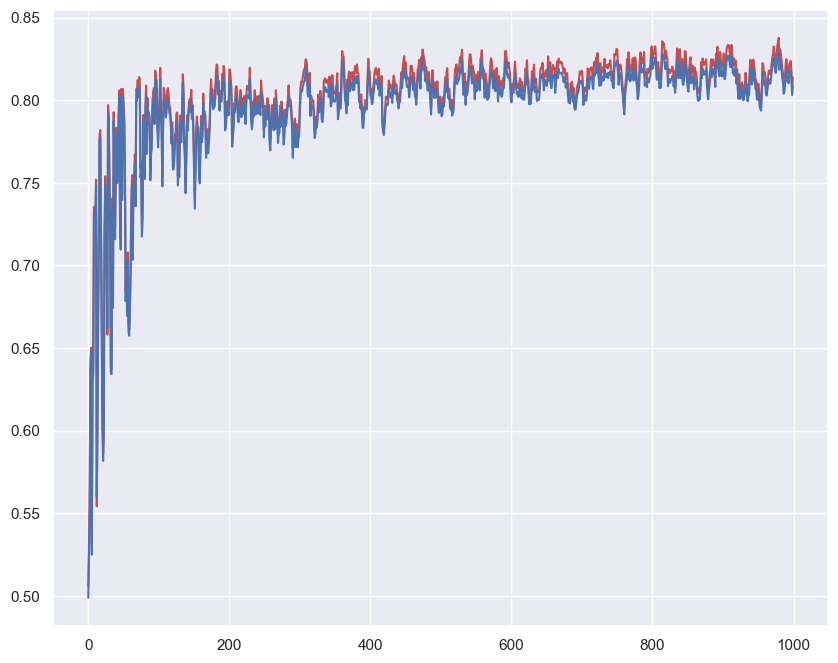

In [21]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b')

## 4. Задание

* Обучим нашу модель **на всех данных**, преобразовав их через ```TfidfVectorizer``` с ```max_features=3000```.

* Параметры модели ```learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3``` и выведем первые 5 самых важных фичей для класса 1 и 5 фичей для класса 0. Убедимся, что они коррелируют с вашей интуицией о хороших/плохих отзывах. 


In [22]:
# Обучите модель
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(review_summaries)
y = train_df.Prediction.values
clf = LogisticRegression()
clf.train(X, y, verbose=True, learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3)

iteration 0 / 1000: loss 0.693181
iteration 100 / 1000: loss 0.637228
iteration 200 / 1000: loss 0.591870
iteration 300 / 1000: loss 0.557030
iteration 400 / 1000: loss 0.543785
iteration 500 / 1000: loss 0.563435
iteration 600 / 1000: loss 0.540159
iteration 700 / 1000: loss 0.553116
iteration 800 / 1000: loss 0.560109
iteration 900 / 1000: loss 0.555437


In [23]:
# Получите индексы фичей
w_without_bias = clf.w[:-1]
pos_features = np.argsort(w_without_bias)[-5:]
neg_features = np.argsort(w_without_bias)[:5]

In [24]:
# Выведите слова
fnames = vectorizer.get_feature_names_out()
print([fnames[p] for p in pos_features])
print([fnames[n] for n in neg_features])

['excellent', 'delicious', 'love', 'best', 'great']
['not', 'disappointed', 'bad', 'too', 'terrible']


## 5. Сравнение с sklearn.linear_model.LogisticRegression

Обучим такую же модель, но из пакета ```sklearn.linear_model``` и убедимся, что имплементация ничем не хуже

In [25]:
from sklearn import linear_model

In [26]:
clf = linear_model.SGDClassifier(max_iter=1000, random_state=42, loss="log_loss", penalty="l2", alpha=1e-3, eta0=1.0, learning_rate="constant")
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.001, eta0=1.0, learning_rate='constant', loss='log_loss',
              random_state=42)

In [27]:
print("Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train)))
print("Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test)))

Train accuracy = 0.816
Test accuracy = 0.812
